# Setup and Imports
Import required libraries including face_recognition, OpenCV, NumPy and configure initial settings.

In [1]:
import face_recognition
import cv2
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Tuple
import time
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt

# Image Preprocessing
Implement image preprocessing functions to handle image loading, resizing, and color space conversion.

In [2]:
def preprocess_image(image_path: str, max_size: int = 640):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Couldn't read {image_path}")
        return None
    
    h, w = img.shape[:2]
    if h > max_size or w > max_size:
        scale = max_size / max(h, w)
        new_size = (int(w * scale), int(h * scale))
        img = cv2.resize(img, new_size)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
def process_single_image(args):
    path, selfie_encoding = args
    try:
        img = preprocess_image(path)
        if img is not None:
            encodings = face_recognition.face_encodings(img, num_jitters=10)
            if encodings:
                distances = face_recognition.face_distance(encodings, selfie_encoding)
                return path, 1 - min(distances)
    except Exception as e:
        print(f"\nError processing {os.path.basename(path)}: {str(e)}")
    return path, 0

# Process a batch of images using multithreading
def process_image_batch(image_paths: List[str], selfie_encoding, max_workers: int = 8):
    results = []
    print(f"\nProcessing {len(image_paths)} images using {max_workers} threads...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_single_image, (path, selfie_encoding))
            for path in image_paths
        ]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing images"):
            path, similarity = future.result()
            if similarity > 0:
                results.append((path, similarity))
    return results

# Find similar faces given a selfie and a directory of photos
def find_similar_faces(selfie_path: str, photos_dir: str, top_k: int = 10) -> List[Tuple[str, float]]:
    start = time.time()
    print(f"\nStarting face search...")
    selfie = preprocess_image(selfie_path)
    if selfie is None:
        raise ValueError("❌ Can't load the selfie - check if the file exists and is an image")
    
    selfie_faces = face_recognition.face_encodings(selfie)
    if not selfie_faces:
        raise ValueError("❌ No face found in selfie!")
    print("✓ Found face in selfie")
    
    valid_extensions = ('.png', '.jpg', '.jpeg')
    photos = [
        os.path.join(photos_dir, f) for f in os.listdir(photos_dir)
        if f.lower().endswith(valid_extensions)
    ]
    print(f"Found {len(photos)} photos to search")
    
    matches = process_image_batch(photos, selfie_faces[0], max_workers=16)
    print(f"\n✓ Search completed in {time.time() - start:.1f} seconds")
    return sorted(matches, key=lambda x: x[1], reverse=True)[:top_k]

In [7]:
# Display results using matplotlib
def display_results(matches: List[Tuple[str, float]]):
    print("display")
    if not matches:
        print("No matches found!")
        return
    
    cols = min(3, len(matches))
    rows = math.ceil(len(matches) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    if rows == 1:
        axes = [axes]  # Wrap in list if only one row

    for idx, (path, similarity) in enumerate(matches):
        row, col = divmod(idx, cols)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[row][col].imshow(img)
            axes[row][col].set_title(f"{os.path.basename(path)}\n{similarity:.2%}", fontsize=10)
            axes[row][col].axis("off")
    
    plt.tight_layout()
    plt.show()

# Results Visualization
Create visualization functions using matplotlib to display matched faces and similarity scores.


Starting face search...
✓ Found face in selfie
Found 200 photos to search

Processing 200 images using 24 threads...


Processing images:   0%|          | 0/200 [00:00<?, ?it/s]


✓ Search completed in 70.5 seconds
display


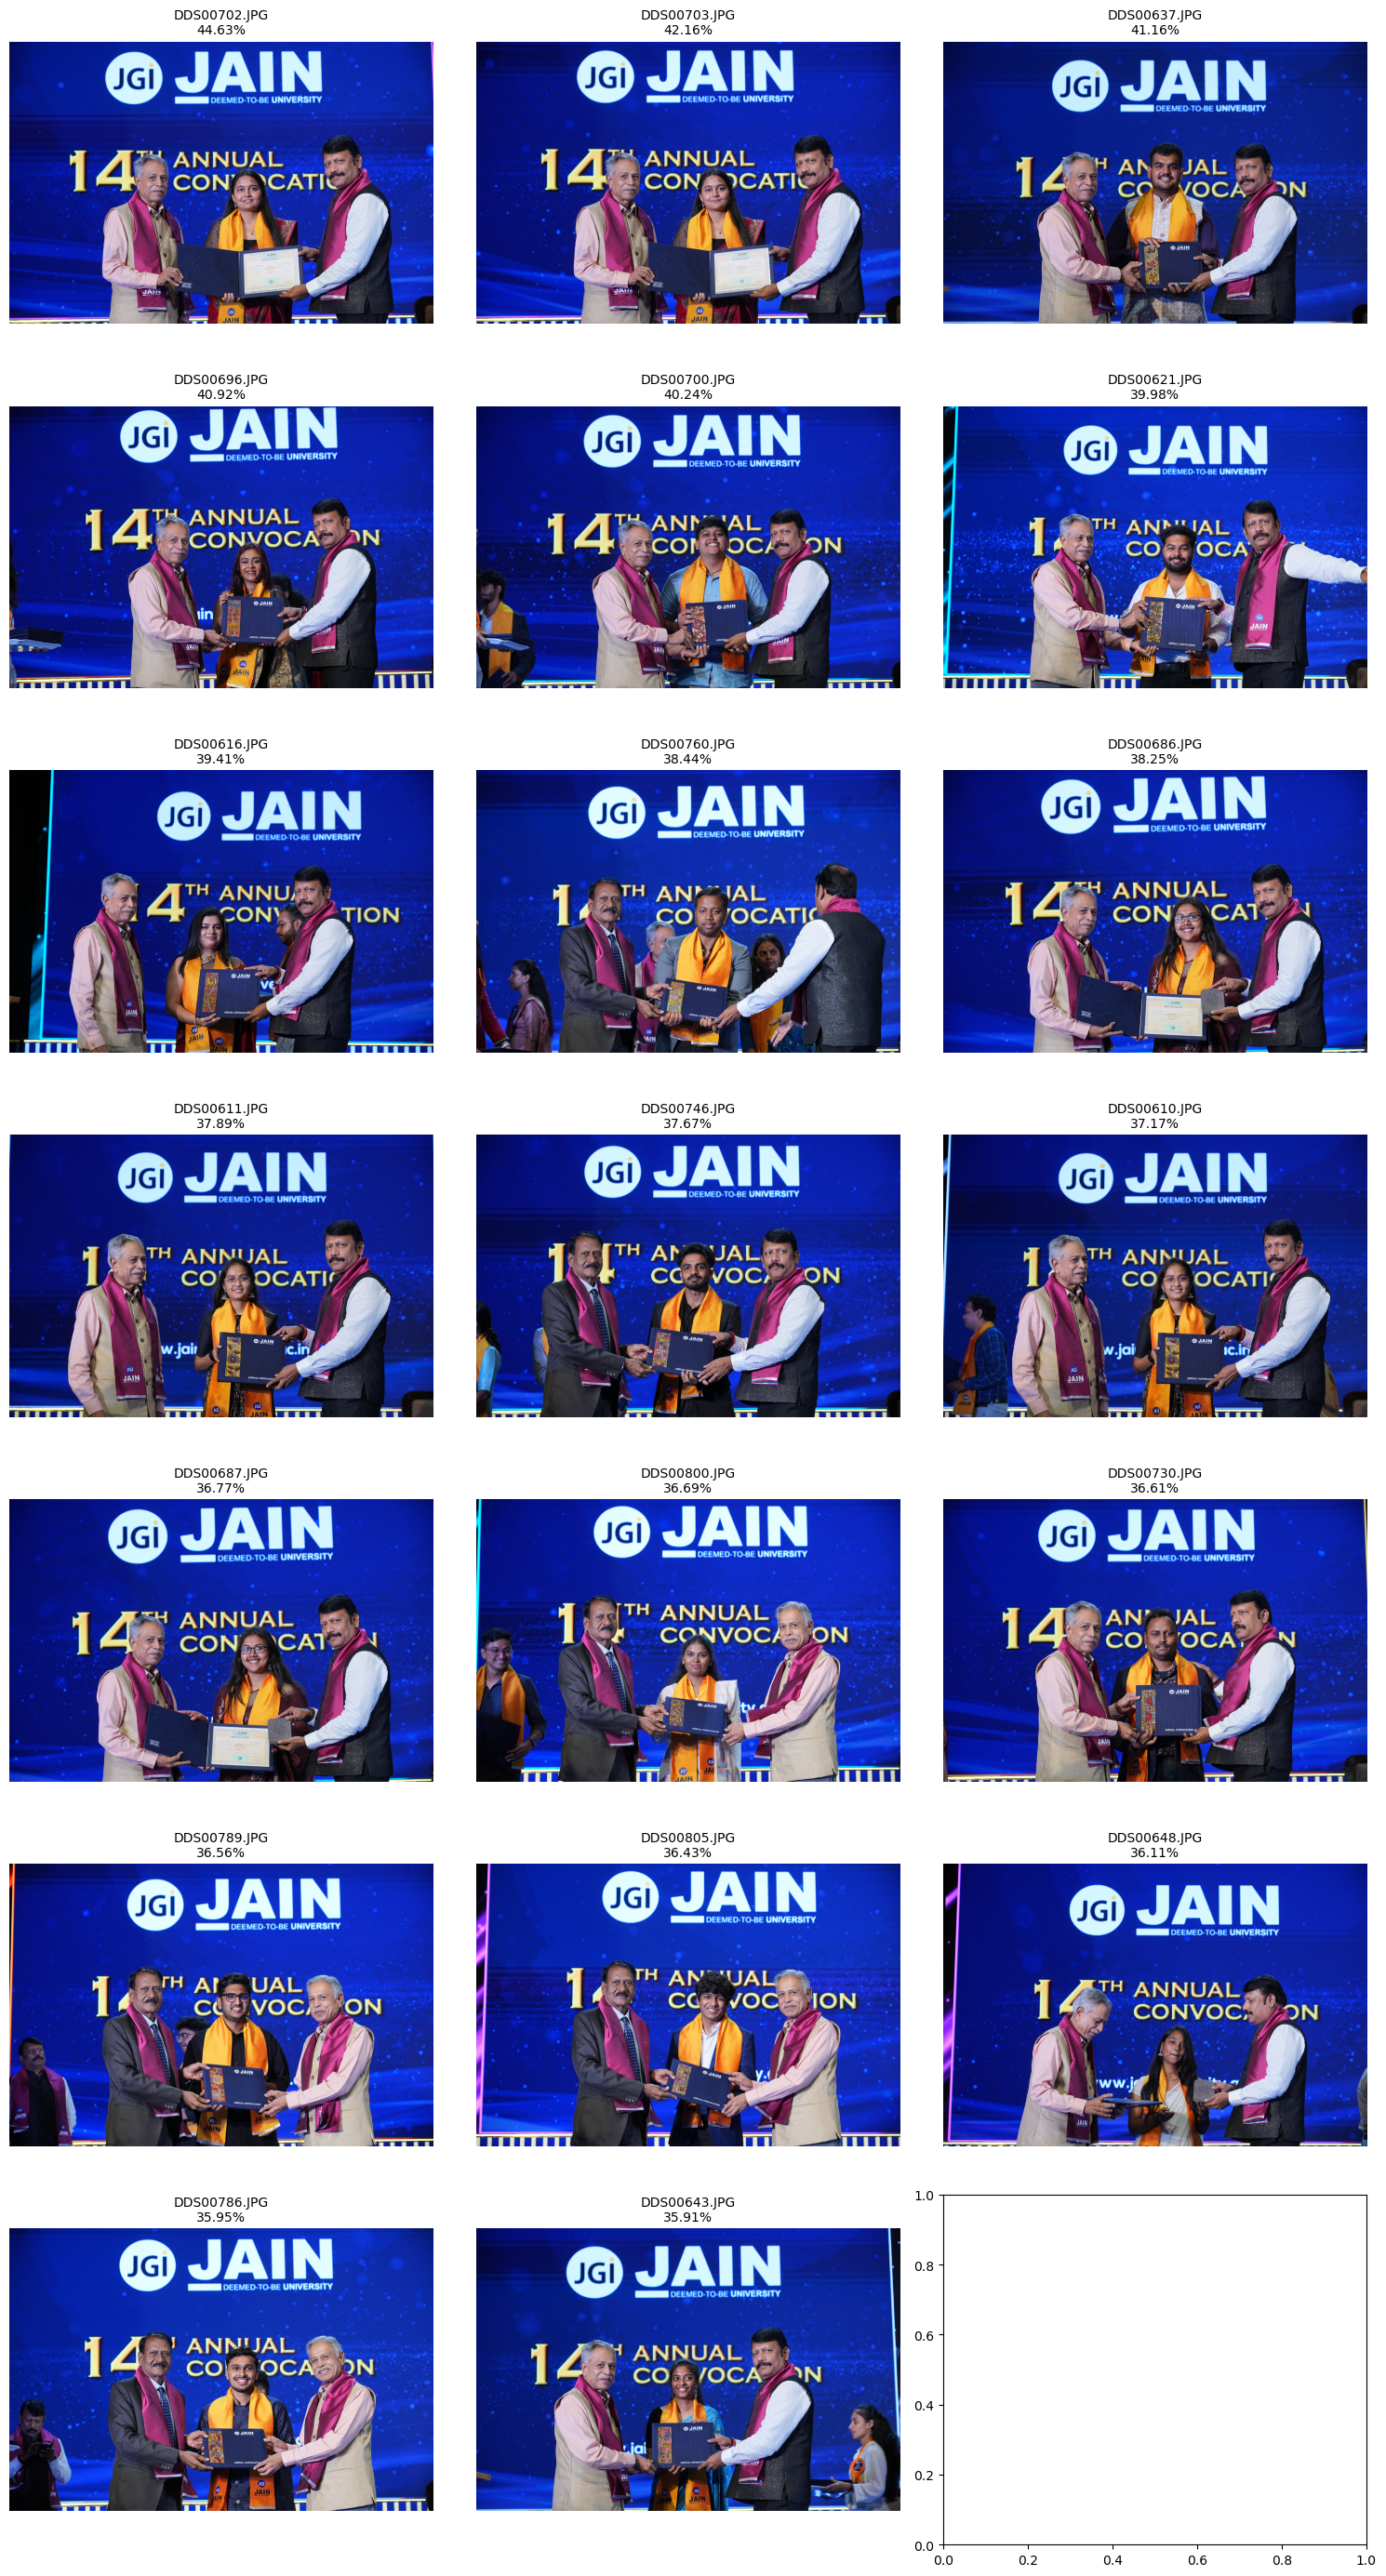

In [11]:
selfie_path = "Z:/Media/Pictures/Screenshots/20241115_095724.jpg"
photos_dir = "C:/Users/Jery/OneDrive/Pictures/Jain-14th-Convocation/13-11-2024 Day 1/02PM to 05PM/Stage 1 (Left)"

try:
    matches = find_similar_faces(selfie_path, photos_dir, 20)
    display_results(matches)
except Exception as e:
    print(f"❌ Error: {str(e)}")